Ce notebook contient l'esemble des essais que j'ai fais pour résoudre le challenge de data camp.

**Exploration des données**

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# Load data
from problem import get_train_data, get_test_data
X_train, Y_train = get_train_data()
X_test, Y_test = get_test_data()

In [3]:
# Convert to DataFrame
x_train = pd.DataFrame(X_train.toarray())
x_test = pd.DataFrame(X_test.toarray())
x_train.head()

,0,1,2,3,4,5,6,7,8,9,...,13541,13542,13543,13544,13545,13546,13547,13548,13549,13550
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
classes = Y_train.categories
print(classes)
annotation ={} 
for i, cls in enumerate(classes):
    annotation[i] = cls
print(annotation)

Index(['Cancer_cells', 'NK_cells', 'T_cells_CD4+', 'T_cells_CD8+'], dtype='object')
{0: 'Cancer_cells', 1: 'NK_cells', 2: 'T_cells_CD4+', 3: 'T_cells_CD8+'}


0. Cancer_cells
1. NK_cells
2. T_cells_CD4+
3. T_cells_CD8+


In [5]:
# Annotation des classes
y_train_encoded = Y_train.codes
y_test_encoded = Y_test.codes
y_train = pd.Series(y_train_encoded)
y_test = pd.Series(y_test_encoded)

y_train.head()

0    2
1    2
2    2
3    2
4    3
dtype: int8

{'classes': Index(['Cancer_cells', 'NK_cells', 'T_cells_CD4+', 'T_cells_CD8+'], dtype='object'), 'occurrences': 3    342
2    336
0    237
1     85
Name: count, dtype: int64}


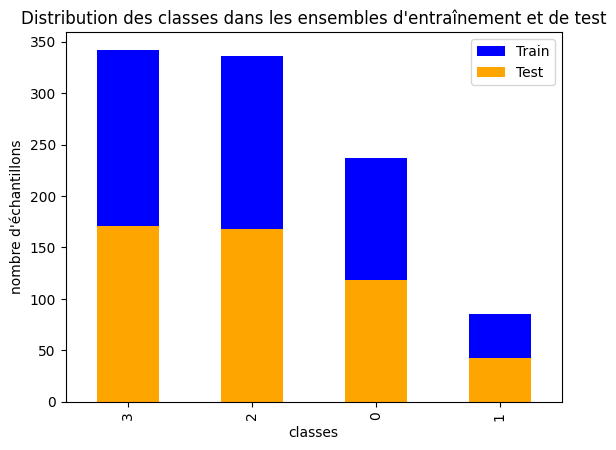

In [6]:
# Exploration des données

## Distribution des classes 
Occurence_train = {}
Occurence_train["classes"] = classes
Occurence_train["occurrences"] = y_train.value_counts()
print(Occurence_train)

y_train.value_counts().plot(kind='bar', color='blue')
y_test.value_counts().plot(kind='bar', color='orange')
plt.xlabel('classes')
plt.ylabel('nombre d\'échantillons')
plt.title('Distribution des classes dans les ensembles d\'entraînement et de test')
plt.legend(['Train','Test'])


Mon premier essai était d'explorer les données et d'essayer de savoir les gènes importantes pour chaque cellule. Le problème c'est que j'ai fait l'exploration sans normalization et jugé que la moitié des gènes ne sont pas assez représentatives pour la majorité des cellules. Les résultats sont dans les diagrammes au-dessous. 
L'idée derrière est aussi le fait d'ajouter des données pour les la classes 1 en se basant sur la distribution de chaque gène dans les cellules détectées cell_1. 

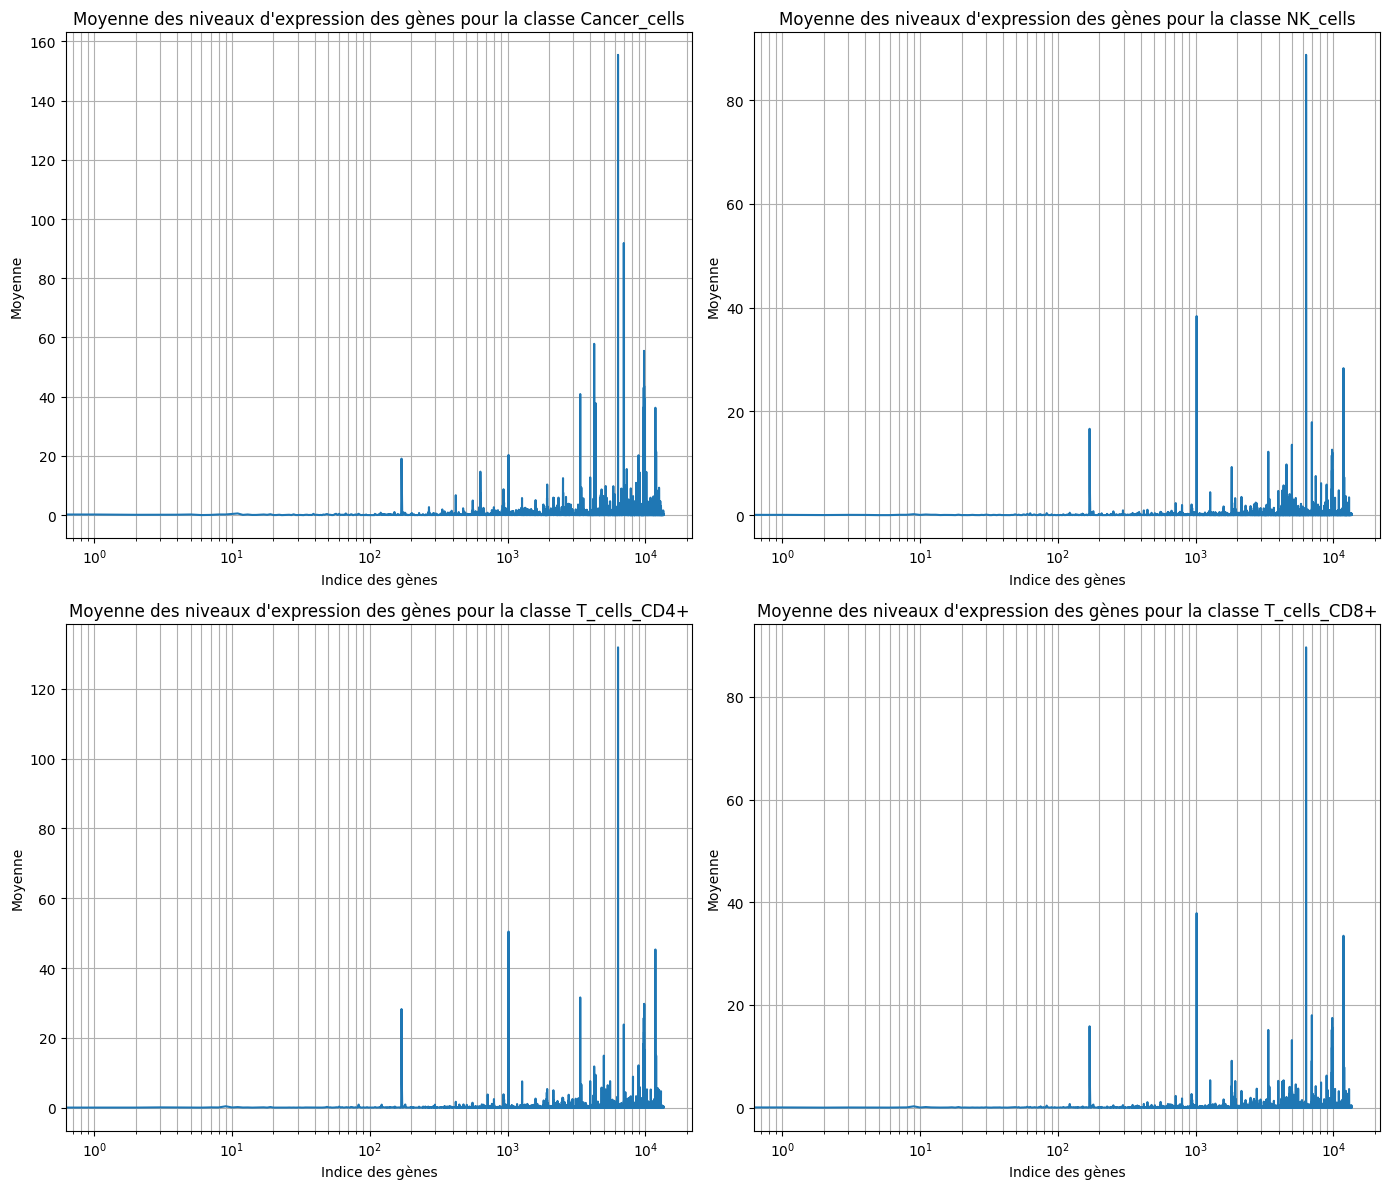

In [7]:
n_classes = 4
n_cols = 2
n_rows = (n_classes + 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 6 * n_rows))
axes = axes.flatten()  

# Répartition des gènes dans les échantillons de toutes les classes
for i in range(n_classes):
    gene_values = x_train[y_train == i]  
    stats = gene_values.describe()       
    mean = stats.loc['mean']             
    
    axes[i].plot(mean.index, mean.values)
    axes[i].set_xscale("log")  
    axes[i].set_title(f'Moyenne des niveaux d\'expression des gènes pour la classe {annotation[i]}')
    axes[i].set_xlabel("Indice des gènes")
    axes[i].set_ylabel("Moyenne")
    axes[i].grid(True, which="both")

# Supprimer les axes vides si besoin
for j in range(n_classes, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()




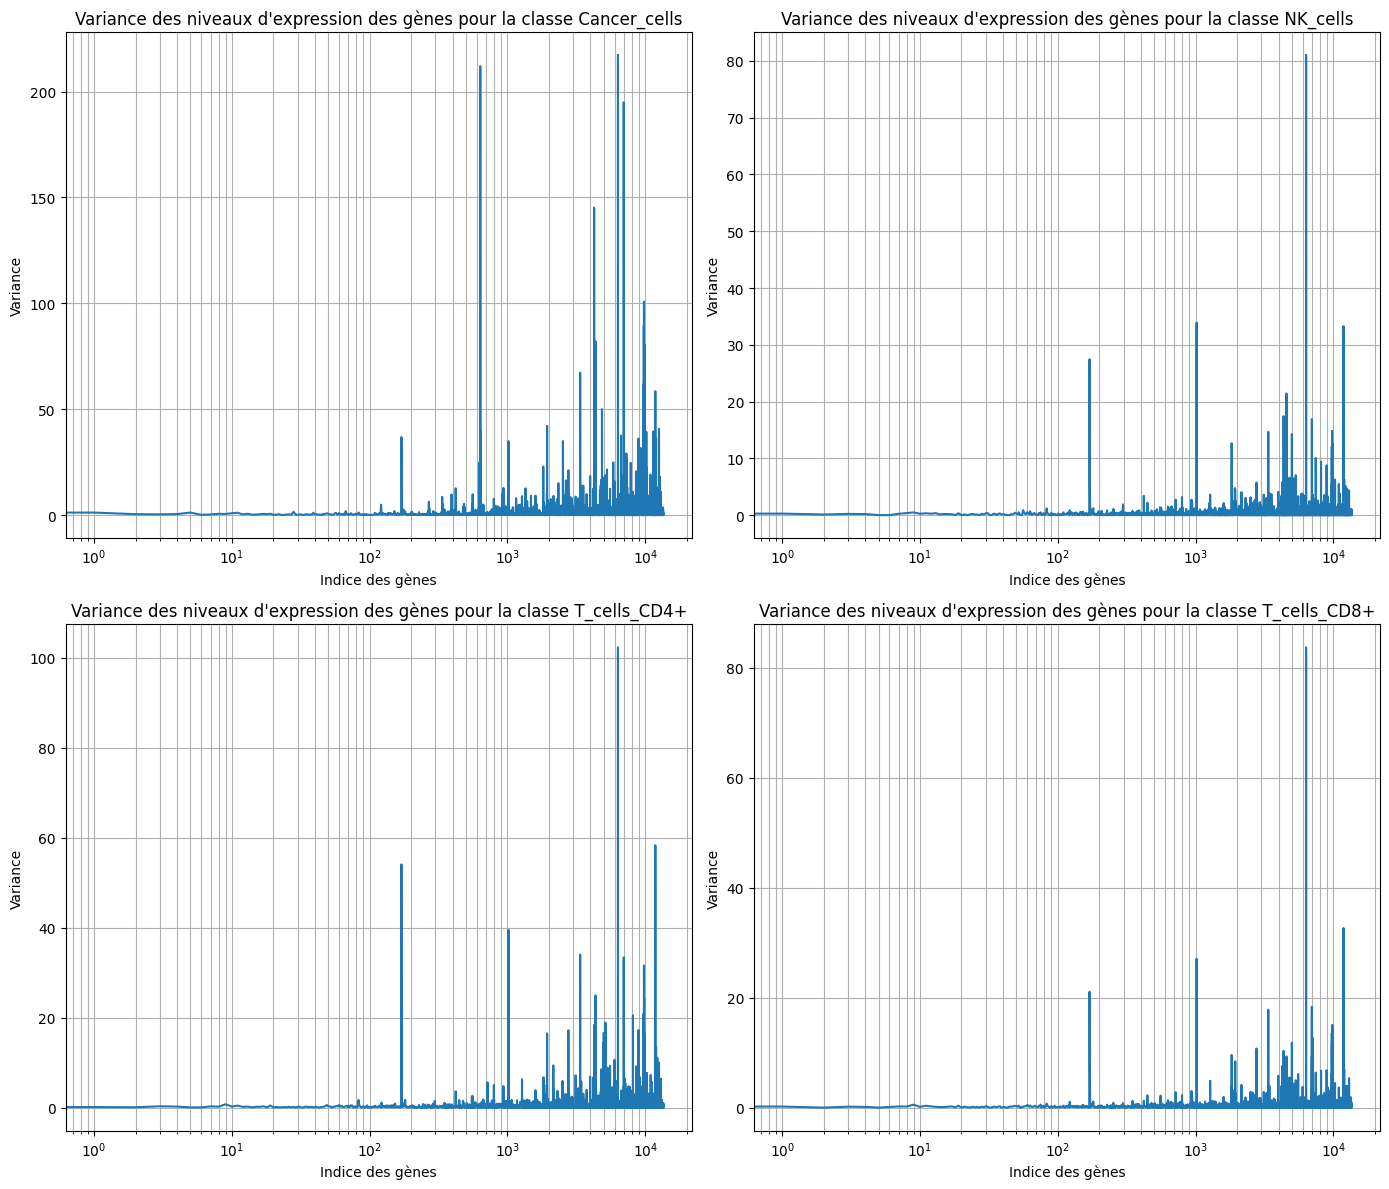

In [15]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 6 * n_rows))
axes = axes.flatten()  

# Répartition des gènes dans les échantillons de toutes les classes
for i in range(n_classes):
    gene_values = x_train[y_train == i]  
    stats = gene_values.describe()       
    mean = stats.loc['std']             
    
    axes[i].plot(mean.index, mean.values)
    axes[i].set_xscale("log") 
    axes[i].set_title(f'Variance des niveaux d\'expression des gènes pour la classe {annotation[i]}')
    axes[i].set_xlabel("Indice des gènes")
    axes[i].set_ylabel("Variance")
    axes[i].grid(True, which="both")

# Supprimer les axes vides si besoin
for j in range(n_classes, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

A partir des digrammes précedants, on remarque qu'environ la moitié  des gènes ( de 0 à 10^2) ne sont pas assez représntatives pour toutes les classes. 
Application de L'ACP pour choisir les features représentatives. 

**Normalisation**
Maintenant je vais essayer de normaliser les données de x_train et les nommer x_train_normalized.

La question qui se pose: pourquoi appliquer une normalisation ? 
 
 - *Correction de la profondeur de séquençage* : Chaque échantillon peut avoir un nombre total de lectures très différent. Sans normalisation, les différences reflètent surtout la quantité totale de séquençage et non l’expression réelle.
 - *Stabilisation de la variance* : Les gènes peu exprimés ont une variance très élevée relative à leur moyenne. Les gènes très exprimés dominent les analyses multivariées (PCA, clustering).
 - *Comparabilité entre échantillons* : Permet de comparer les niveaux d’expression entre échantillons et conditions.

 


In [8]:

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Normalisation CPM
cpm_train = x_train.div(x_train.sum(axis=1), axis=0) * 1e6
cpm_test = x_test.div(x_test.sum(axis=1), axis=0) * 1e6
# Log-transformation
x_train_normalized = np.log2(cpm_train + 1)
x_test_normalized = np.log2(cpm_test + 1)


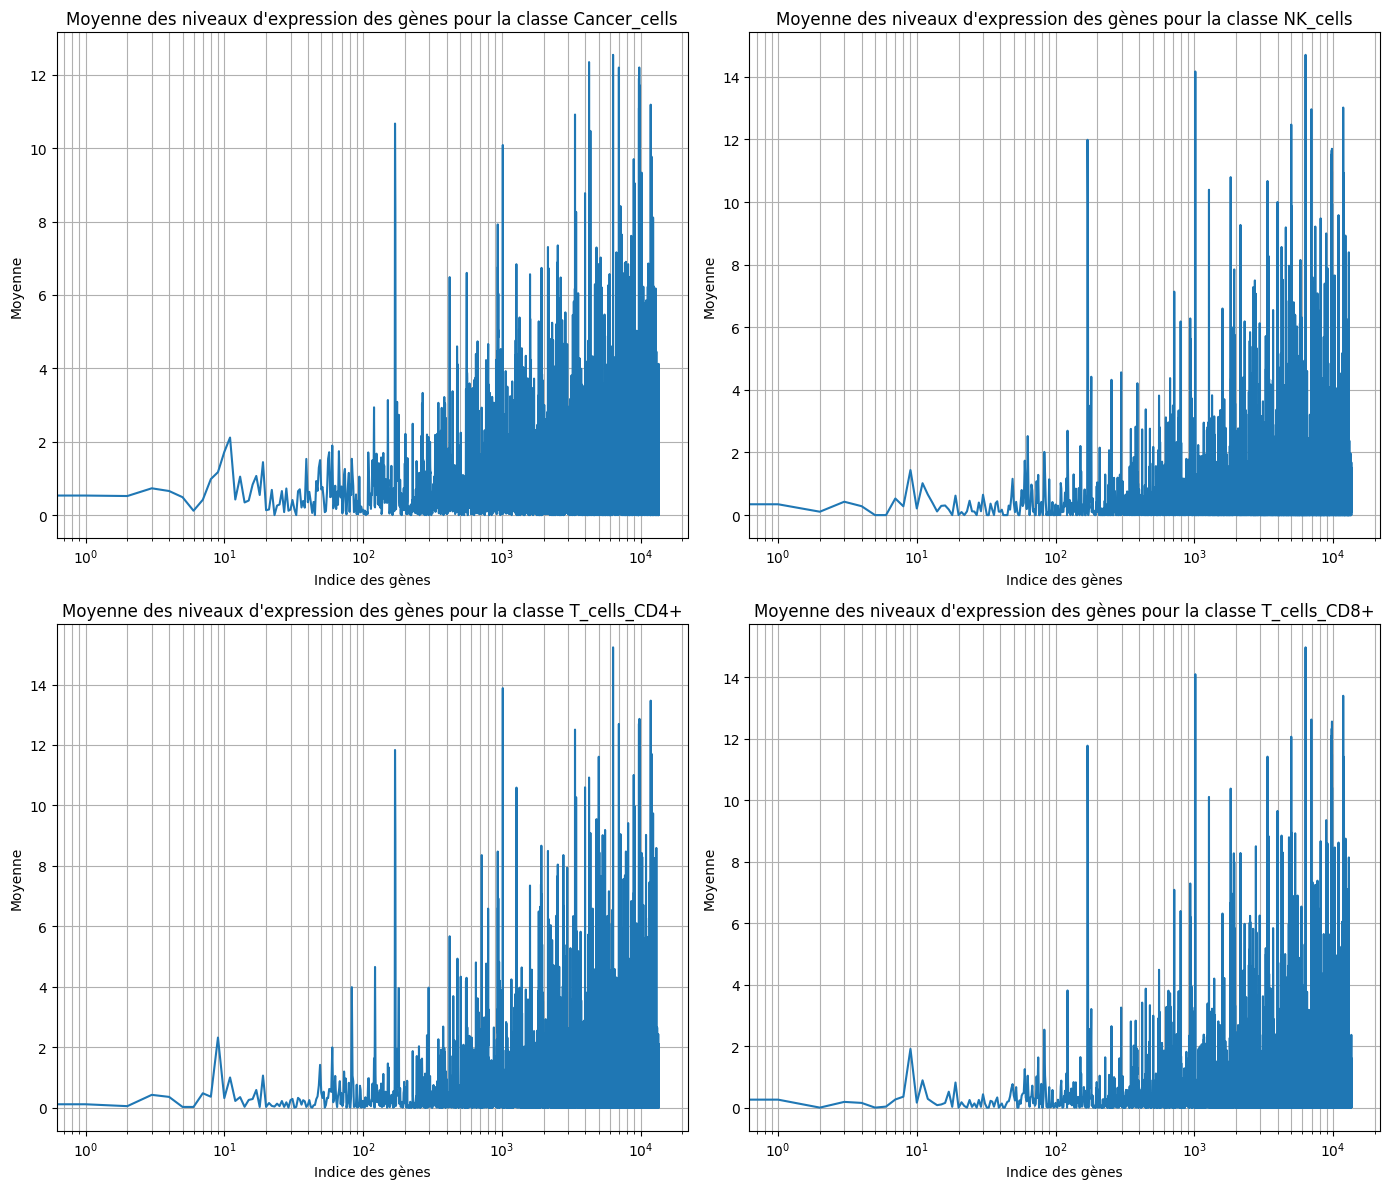

In [27]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 6 * n_rows))
axes = axes.flatten()  

# Répartition des gènes dans les échantillons de toutes les classes
for i in range(n_classes):
    gene_values = x_train_normalized[y_train == i]  
    stats = gene_values.describe()       
    mean = stats.loc['mean']             
    
    axes[i].plot(mean.index, mean.values)
    axes[i].set_xscale("log")  
    axes[i].set_title(f'Moyenne des niveaux d\'expression des gènes pour la classe {annotation[i]}')
    axes[i].set_xlabel("Indice des gènes")
    axes[i].set_ylabel("Moyenne")
    axes[i].grid(True, which="both")

# Supprimer les axes vides si besoin
for j in range(n_classes, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()




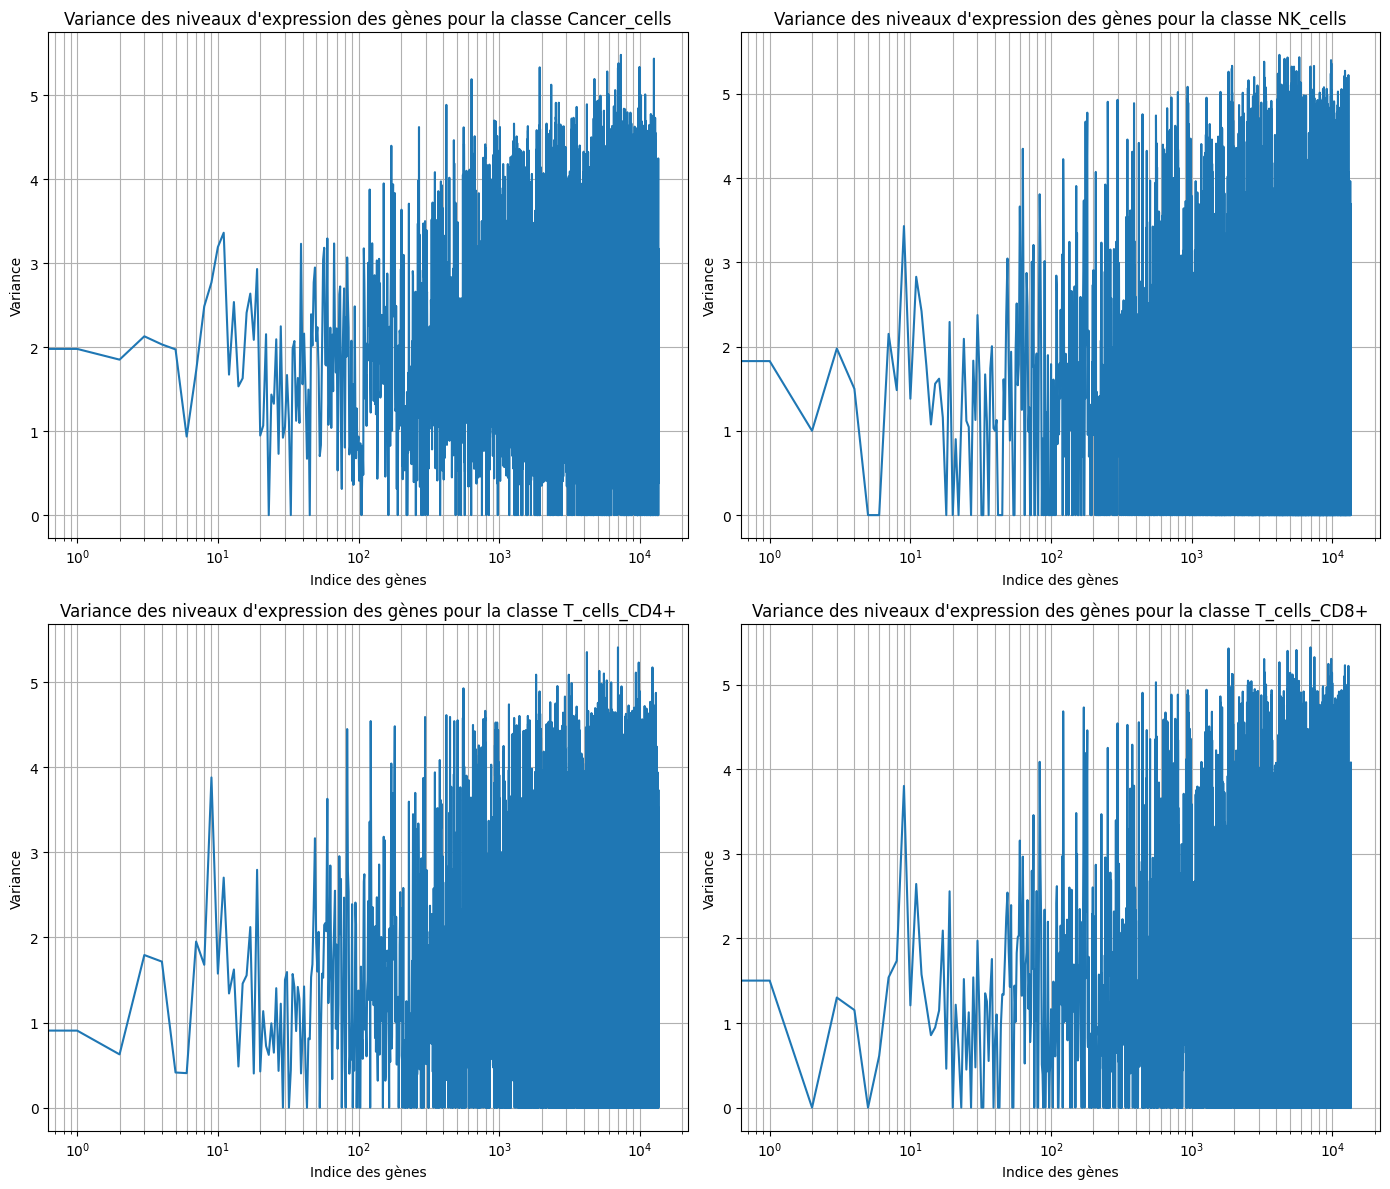

In [28]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 6 * n_rows))
axes = axes.flatten()  

# Répartition des gènes dans les échantillons de toutes les classes
for i in range(n_classes):
    gene_values = x_train_normalized[y_train == i]  
    stats = gene_values.describe()       
    mean = stats.loc['std']             
    
    axes[i].plot(mean.index, mean.values)
    axes[i].set_xscale("log")  
    axes[i].set_title(f'Variance des niveaux d\'expression des gènes pour la classe {annotation[i]}')
    axes[i].set_xlabel("Indice des gènes")
    axes[i].set_ylabel("Variance")
    axes[i].grid(True, which="both")

# Supprimer les axes vides si besoin
for j in range(n_classes, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()




**Data Augmentation**



L'objectif de cette partie est de régler le problème des données minoritaires de la cellule 1. 

**Entraînement des modèles** 


In [2]:
!pip install xgboost

  Using cached xgboost-3.1.1-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.1.1-py3-none-win_amd64.whl (72.0 MB)



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
# Construction de Piplines 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# LASSO Logistic Regression
from sklearn.linear_model import LogisticRegression

pipe_lasso = Pipeline([
    ("Scaler", StandardScaler()),
    ("PCA", PCA(n_components=0.9)),  
    ("LASSO", LogisticRegression(penalty='l1', solver='saga', C=1, max_iter=5000))
])

# SVM avec kernel RBF
from sklearn.svm import SVC

pipe_svm = Pipeline([
    ("Scaler", StandardScaler()),           
    ("PCA", PCA(n_components=0.9)),        
    ("SVM", SVC(kernel="rbf", C=1, gamma='scale'))  
])

# XGBoost Classifier
from xgboost import XGBClassifier
pipe_xgb = Pipeline([
    ("Scaler", StandardScaler()),           
    ("PCA", PCA(n_components=0.9)),       
    ("XGB", XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
])


# Stacking Classifier with Random Forest

from sklearn.ensemble import RandomForestClassifier, StackingClassifier

pipe_rf = Pipeline([
    ("Scaler", StandardScaler()),
    ("PCA", PCA(n_components=50)),
    ("RF", RandomForestClassifier(max_depth=5, n_estimators=100, max_features=3))
])


stack_pipeline = StackingClassifier(
    estimators=[
        ("SVM", pipe_svm),
        ("LASSO", pipe_lasso),
        ("RF", pipe_rf)
    ],
    final_estimator=LogisticRegression(),  
    passthrough=True,  
    cv=5
)

from lightgbm import LGBMClassifier

pipe_LGBM = Pipeline([
    ("LGBM", LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight='balanced',
    objective='multiclass',
    random_state=42,
    n_jobs=-1
))
])



In [10]:
from sklearn.metrics import balanced_accuracy_score
from problem import BalancedAccuracy
from sklearn.model_selection import cross_val_score

**Lasso**

Train balanced accuracy : 1.000
Test balanced accuracy : 0.776


Text(0.5, 1.0, 'Confusion matrix on test set Lasso model')

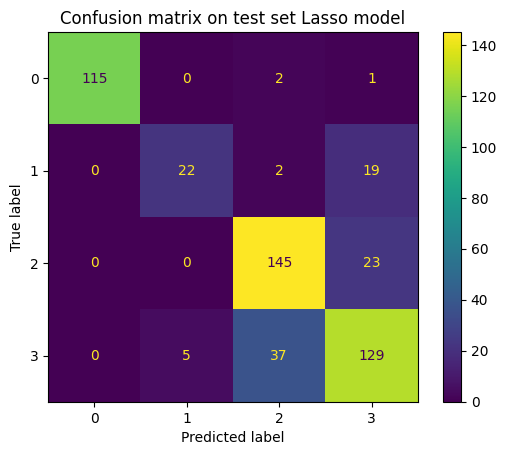

In [11]:
# fit on train
pipe_lasso.fit(x_train_normalized, y_train)
y_tr_pred = pipe_lasso.predict(x_train_normalized)
# predict on test
y_te_pred = pipe_lasso.predict(x_test_normalized)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# compute balanced accuracy and confusion matrix
print(f"Train balanced accuracy : {balanced_accuracy_score(y_train, y_tr_pred):.3f}")
print(f"Test balanced accuracy : {balanced_accuracy_score(y_test, y_te_pred):.3f}")
cm = confusion_matrix(y_test, y_te_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_lasso.classes_, )
disp.plot()
plt.title("Confusion matrix on test set Lasso model")

In [37]:
scores_train = cross_val_score(pipe_lasso, x_train_normalized, y_train, cv=5, scoring='accuracy')
scores_test = cross_val_score(pipe_lasso, x_test_normalized, y_test, cv=5, scoring='accuracy')

print("Scores CV pour chaque fold :", scores_train)
print("Accuracy moyenne sur data_train :", np.mean(scores_train))

print("Scores CV pour chaque fold sur data_test :", scores_test)
print("Accuracy moyenne sur data_test :", np.mean(scores_test))

Scores CV pour chaque fold : [0.82  0.83  0.825 0.835 0.845]
Accuracy moyenne sur data_train : 0.8309999999999998
Scores CV pour chaque fold sur data_test : [0.8  0.85 0.77 0.87 0.82]
Accuracy moyenne sur data_test : 0.8220000000000001


**SVM**

Train balanced accuracy : 0.913
Test balanced accuracy : 0.593


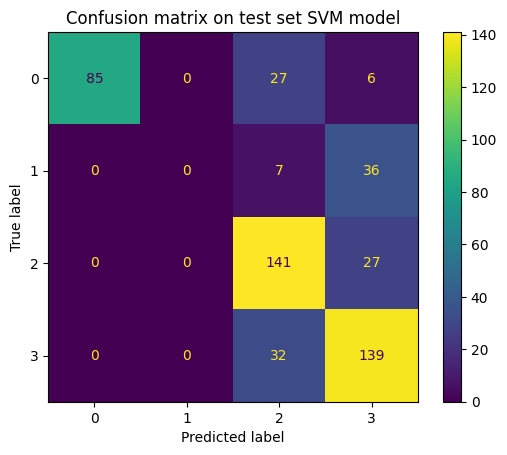

In [12]:
# fit on train
pipe_svm.fit(x_train_normalized, y_train)
y_tr_pred = pipe_svm.predict(x_train_normalized)
# predict on test
y_te_pred = pipe_svm.predict(x_test_normalized)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# compute balanced accuracy and confusion matrix
print(f"Train balanced accuracy : {balanced_accuracy_score(y_train, y_tr_pred):.3f}")
print(f"Test balanced accuracy : {balanced_accuracy_score(y_test, y_te_pred):.3f}")
cm = confusion_matrix(y_test, y_te_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_svm.classes_, )
disp.plot()
plt.title("Confusion matrix on test set SVM model");


In [39]:
scores_train = cross_val_score(pipe_svm, x_train_normalized, y_train, cv=5, scoring='accuracy')
scores_test = cross_val_score(pipe_svm, x_test_normalized, y_test, cv=5, scoring='accuracy')

print("Scores CV pour chaque fold sur data_train :", scores_train)
print("Accuracy moyenne sur data_train :", np.mean(scores_train))

print("Scores CV pour chaque fold sur data_test :", scores_test)
print("Accuracy moyenne sur data_test :", np.mean(scores_test))

Scores CV pour chaque fold sur data_train : [0.67  0.69  0.735 0.7   0.735]
Accuracy moyenne sur data_train : 0.706
Scores CV pour chaque fold sur data_test : [0.57 0.59 0.55 0.58 0.61]
Accuracy moyenne sur data_test : 0.58


**XGBoost**

C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [15:49:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Train balanced accuracy : 1.000
Test balanced accuracy : 0.777


Text(0.5, 1.0, 'Confusion matrix on test set XGboost')

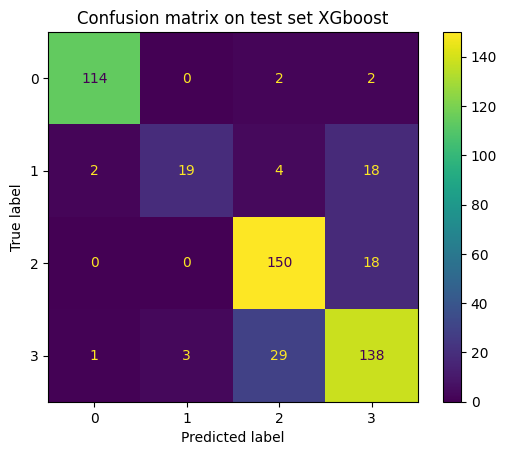

In [13]:
# fit on train
pipe_xgb.fit(x_train_normalized, y_train)
y_tr_pred = pipe_xgb.predict(x_train_normalized)
# predict on test
y_te_pred = pipe_xgb.predict(x_test_normalized)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# compute balanced accuracy and confusion matrix
print(f"Train balanced accuracy : {balanced_accuracy_score(y_train, y_tr_pred):.3f}")
print(f"Test balanced accuracy : {balanced_accuracy_score(y_test, y_te_pred):.3f}")
cm = confusion_matrix(y_test, y_te_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_xgb.classes_, )
disp.plot()
plt.title("Confusion matrix on test set XGboost")

In [40]:
scores_train = cross_val_score(pipe_xgb, x_train_normalized, y_train, cv=5, scoring='accuracy')
scores_test = cross_val_score(pipe_xgb, x_test_normalized, y_test, cv=5, scoring='accuracy')

print("Scores CV pour chaque fold sur data_train:", scores_train)
print("Accuracy moyenne sur data train :", np.mean(scores_train))

print("Scores CV pour chaque fold sur data_test:", scores_test)
print("Accuracy moyenne sur data_test :", np.mean(scores_test))

c:\Users\hp\Desktop\Data_Camp\scmark-classification-team_avengers\ramp_env\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:39:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hp\Desktop\Data_Camp\scmark-classification-team_avengers\ramp_env\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:39:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hp\Desktop\Data_Camp\scmark-classification-team_avengers\ramp_env\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:40:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hp\Desktop\Data_Camp\scmark-classification-team_avengers\ramp_env\Lib\

Scores CV pour chaque fold sur data_train: [0.825 0.815 0.82  0.845 0.855]
Accuracy moyenne sur data train : 0.8320000000000001
Scores CV pour chaque fold sur data_test: [0.78 0.82 0.77 0.8  0.74]
Accuracy moyenne sur data_test : 0.782


**Stacking Model**

C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train balanced accuracy : 1.000
Test balanced accuracy : 0.778


Text(0.5, 1.0, 'Confusion matrix on test set Stacking model')

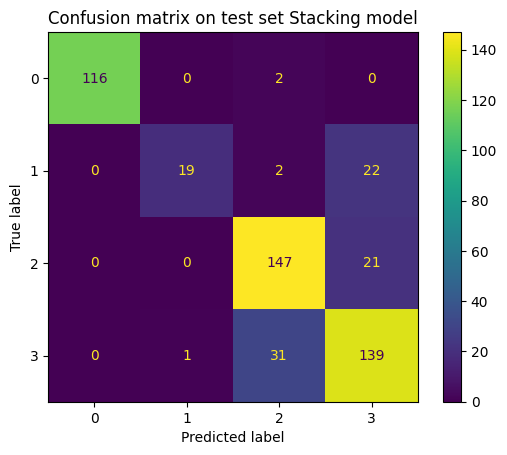

In [14]:
# fit on train
stack_pipeline.fit(x_train_normalized, y_train)
y_tr_pred = stack_pipeline.predict(x_train_normalized)
# predict on test
y_te_pred = stack_pipeline.predict(x_test_normalized)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# compute balanced accuracy and confusion matrix
print(f"Train balanced accuracy : {balanced_accuracy_score(y_train, y_tr_pred):.3f}")
print(f"Test balanced accuracy : {balanced_accuracy_score(y_test, y_te_pred):.3f}")
cm = confusion_matrix(y_test, y_te_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=stack_pipeline.classes_, )
disp.plot()
plt.title("Confusion matrix on test set Stacking model")

In [41]:
scores_train = cross_val_score(stack_pipeline, x_train_normalized, y_train, cv=5, scoring='accuracy')
scores_test = cross_val_score(stack_pipeline, x_test_normalized, y_test, cv=5, scoring='accuracy')

print("Scores CV pour chaque fold sur data_train:", scores_train)
print("Accuracy moyenne sur data train :", np.mean(scores_train))

print("Scores CV pour chaque fold sur data_test:", scores_test)
print("Accuracy moyenne sur data_test :", np.mean(scores_test))

Scores CV pour chaque fold sur data_train: [0.865 0.86  0.865 0.88  0.88 ]
Accuracy moyenne sur data train : 0.8699999999999999
Scores CV pour chaque fold sur data_test: [0.78 0.82 0.8  0.82 0.83]
Accuracy moyenne sur data_test : 0.8099999999999999


**LightXGBM**

In [16]:
import seaborn as sns

In [31]:
lgbm = pipe_LGBM.fit(x_train_normalized, y_train)
y_pred_train = lgbm.predict(x_train_normalized)
acc_train = balanced_accuracy_score(y_train, y_pred_train)
print("Accuracy score for train dataset :", acc_train)


y_pred_test = lgbm.predict(x_test_normalized)
acc_test = balanced_accuracy_score(y_test, y_pred_test)
print("Accuracy score for test dataset :", acc_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.344358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 359527
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 9766
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

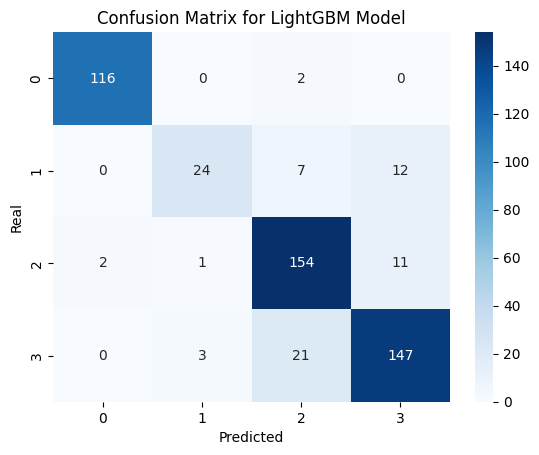

In [32]:
cm = confusion_matrix(y_test, y_pred_test)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Confusion Matrix for LightGBM Model')
plt.show()

In [33]:
scores_train = cross_val_score(pipe_LGBM, x_train_normalized, y_train, cv=5, scoring='accuracy')
scores_test = cross_val_score(pipe_LGBM, x_test_normalized, y_test, cv=5, scoring='accuracy')

print("Scores CV pour chaque fold sur data_train:", scores_train)
print("Accuracy moyenne sur data train :", np.mean(scores_train))

print("Scores CV pour chaque fold sur data_test:", scores_test)
print("Accuracy moyenne sur data_test :", np.mean(scores_test))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.361391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 288291
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 9057
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with